In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# Graphs

- $\frac{dT}{dt} = T + h * T + a \cdot log(V) + b \cdot log(W) = h \cdot T + \log(V^a \cdot W^b)$
- $\frac{dW}{dt} = W$
- $\frac{dV}{dt} = a \cdot V +b \cdot e^{(-\frac{(T-T_0*d)^2}{c})}$

In [3]:
t_max = 50
t_min= 20
t_crit = 40
h = 0.1
W = 0.5
p = 0.1

In [4]:
data = pd.read_csv("../data/yearly_p_t_v_wide.csv")
data = data[data["country"] == "Germany"]
##data = data.pivot(columns=["variable"], values=["value"],index="city").reset_index()
##data.columns = ["city","PM2.5 (μg/m3)", "V", "T", "W"]
#data = data.loc[:,["city","PM2.5 (μg/m3)", "V", "T", "W"]].groupby("city").mean()
#data.columns = ["P", "V", "T", "W"]
#data = data.dropna()
cities_df = [cur_df for cur_df in data.groupby("city")]

In [80]:
data

,country,year,city,val_idx,V,P,T
0,Germany,2002,Berlin,1,906.285899,28.000000,9.844027
1,Germany,2002,Bremen,1,1460.106010,28.000000,10.051041
2,Germany,2002,Dortmund,1,53.021105,29.000000,10.429123
3,Germany,2002,Dresden,1,430.816843,32.000000,9.225726
4,Germany,2002,Frankfurt,1,253.717734,30.500000,10.529425
...,...,...,...,...,...,...,...
112,Germany,2014,Frankfurt,13,253.736430,21.500000,11.429452
113,Germany,2014,Leipzig,13,304.170393,26.333333,11.017699
114,Germany,2014,Mannheim,13,103.466212,18.000000,11.781699
115,Germany,2014,München,13,1601.125459,20.500000,10.273151


## Temp vs Particulates + Vegetation

In [5]:
def fit_function(data, f, y):
    na_data = ~y.isna()
    data = data.loc[na_data, :]
    y = y[na_data]
    popt_linear, _ = curve_fit(f, data, y)
    return popt_linear

def plot_paras(data, in_var, target_var, res_paras, fixed_vars, n_col = 3, n_row = 3):
    fig, axs = plt.subplots(n_row, n_col, figsize = (10, 10))
    for cur_col in range(n_col):
        for cur_row in range(n_row):
            cur_df_id = cur_col * n_col + cur_row
            cur_x = cur_col
            cur_y = cur_row
            cur_paras = res_paras[cur_df_id]
            cur_df = data[cur_df_id][1]
            fixed_para = [cur_df[cur_fixed_var].mean() for cur_fixed_var in fixed_vars]
            free_var = [cur_var for cur_var in in_var if cur_var not in fixed_vars][0]
            axs[cur_x, cur_y].scatter(cur_df[free_var],
                cur_df[target_var], marker = "x", label = "Data")
            plot_data = dict(zip(fixed_vars, fixed_para))
            plot_data[free_var[0]] = cur_df[free_var]
            axs[cur_x, cur_y].plot(cur_df[free_var],dt_linear(pd.DataFrame(plot_data), *cur_paras),
                label = "pred", color = "orange")
            axs[cur_x, cur_y].legend()
            axs[cur_x, cur_y].set_title(cities_df[cur_df_id][0])

<Axes: xlabel='variable', ylabel='value'>

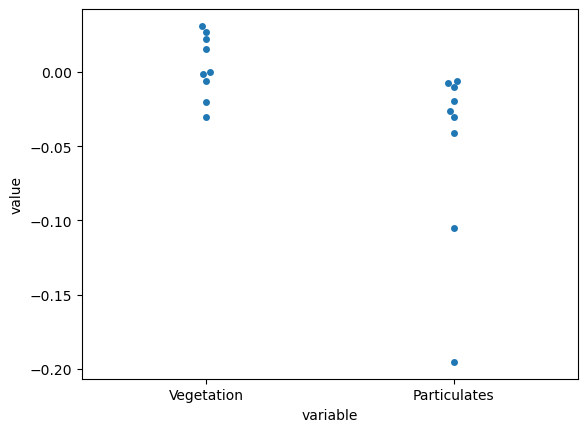

In [68]:
t_paras_df = pd.DataFrame(res_paras)
t_paras_df.columns = ["Vegetation", "Particulates"]
sns.swarmplot(x="variable", y="value", data = pd.melt(t_paras_df))

## Particulates VS Temperature & Vegetation

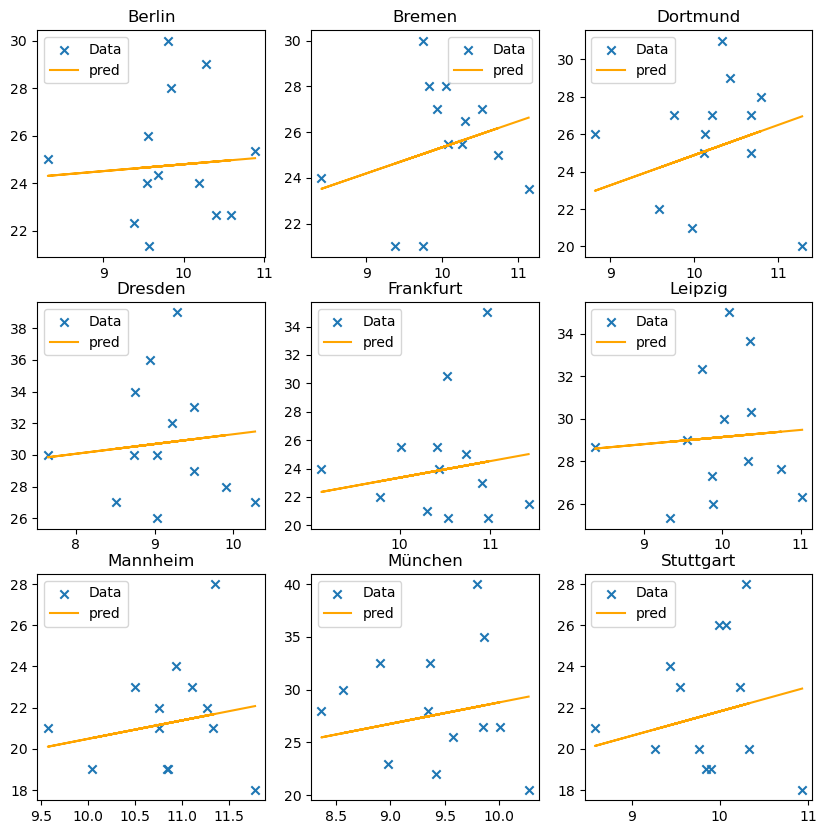

In [91]:
in_var = ["P", "T", "V"]
target_var = "P"
def dt_linear(PTV , p, r):
    P, T, V = [PTV[cur_var] for cur_var in in_var]
    return  p * P * T - r * V

res_paras = [fit_function(cur_df[1].loc[:, in_var], dt_linear, cur_df[1][target_var].shift(-1)) for cur_df in data.groupby("city")]
plot_paras(cities_df, in_var, target_var, res_paras, fixed_vars=["V", "P"])

<Axes: xlabel='variable', ylabel='value'>

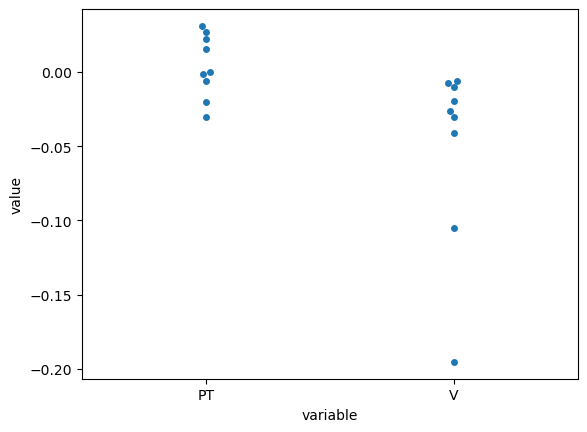

In [97]:
t_paras_df = pd.DataFrame(res_paras)
t_paras_df.columns = ["PT", "V"]
sns.swarmplot(x="variable", y="value", data = pd.melt(t_paras_df))

## Water vs Temp

[ 4.93823918e+02 -7.12765564e+02 -4.63552030e-02]


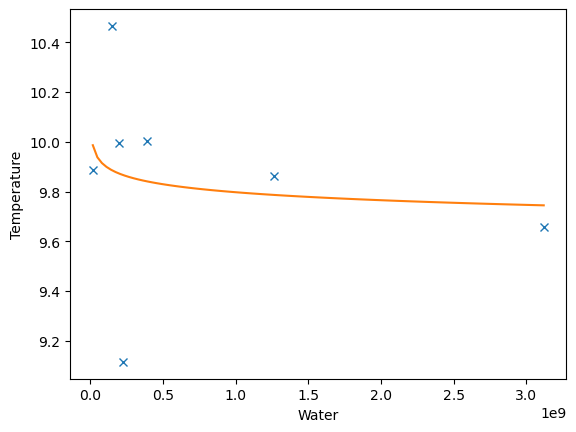

In [19]:
# Function candidates
def dt(W, h, a, b):
    T = data["T"].mean()
    V = data["V"].mean()
    return T + h * T + a * np.log(V) + b * np.log(W)

# Perform the curve fitting
popt, pcov = curve_fit(dt, data["W"], data["T"])

x_fit = np.linspace(min(data["W"]), max(data["W"]), 100)
y_fit = dt(x_fit, *popt)

plt.plot(data["W"],data["T"],"x")
plt.plot(x_fit,y_fit)
plt.ylabel("Temperature")
plt.xlabel("Water")
print(popt)

## Vegetation vs Temp

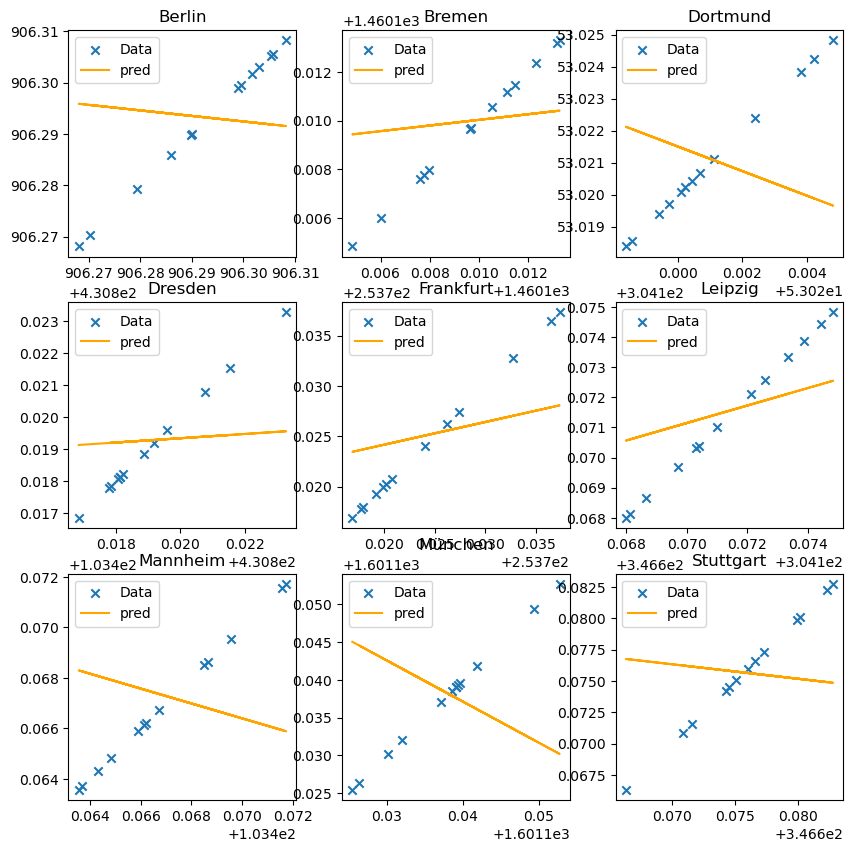

In [106]:
# Function candidates

in_var = ["V"]
target_var = "V"
def dt_linear(V , s, g):
    V = V["V"]
    return s + g*V

res_paras = [fit_function(cur_df[1].loc[:, in_var], dt_linear, cur_df[1][target_var].shift(-1)) for cur_df in data.groupby("city")]
plot_paras(cities_df, in_var, target_var, res_paras, fixed_vars=[])

<Axes: xlabel='variable', ylabel='value'>

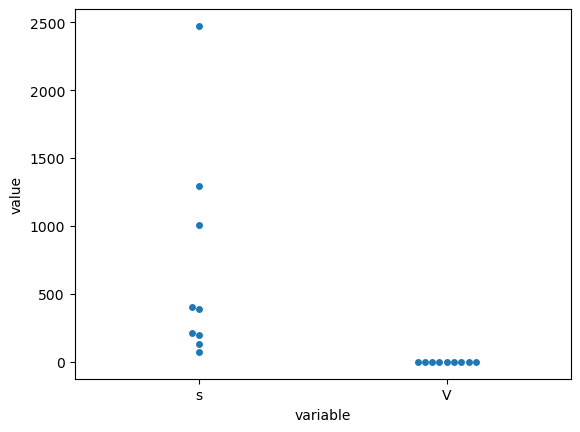

In [108]:
t_paras_df = pd.DataFrame(res_paras)
t_paras_df.columns = ["s", "V"]
sns.swarmplot(x="variable", y="value", data = pd.melt(t_paras_df))

bell: [4.88491687e-01 2.61605977e+03 3.45681363e-02 9.69686654e-01]


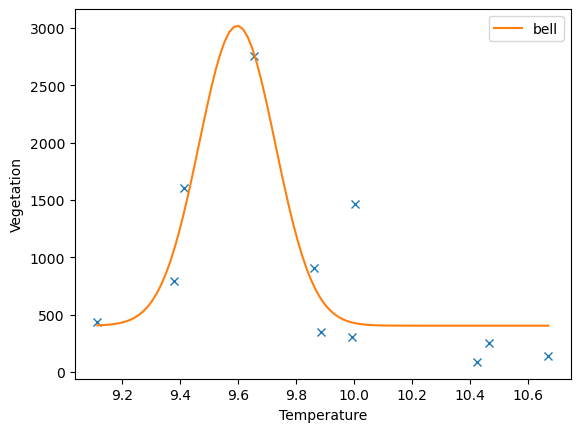

In [7]:
# Function candidates
def dV_bell(T, a, b, c, d):
    mean_temp = data["T"].mean()
    mean_v = data["V"].mean()
    return a*mean_v+b*np.exp(-((T - mean_temp*d)**2)/c)

# Perform the curve fitting
popt_bell, pcov_bell = curve_fit(dV_bell, data["T"], data["V"], bounds=([-np.inf,-np.inf, -np.inf, -1], [np.inf, np.inf, np.inf, 1]),
                                p0 =[1, 1000, 1, 1])

x_fit = np.linspace(min(data["T"]), max(data["T"]), 100)
y_fit_bell = dV_bell(x_fit, *popt_bell)

plt.plot(data["T"],data["V"],"x")
plt.plot(x_fit,y_fit_bell, label="bell")
plt.xlabel("Temperature")
plt.ylabel("Vegetation")
plt.legend(loc="best")
print("bell:",popt_bell)

# Diff systems parameter approximation

In [5]:
import numpy as np
from scipy.optimize import minimize

# Assume data is given as numpy arrays
# t: time array
# T, P, V: observed data arrays for temperature, pressure, and volume respectively
t = data["year"].unique()
values = []
for name, city in data.groupby("city"):
    T = city["T"]
    P = city["P"]
    V = city["V"]

    # Compute numerical derivatives using finite differences
    dT_dt = np.gradient(T, t)
    dP_dt = np.gradient(P, t)
    dV_dt = np.gradient(V, t)

    # Define the objective function to minimize
    def objective(params):
        h, c, p, r, s, g = params
        residuals_T = dT_dt - (h * P - c * V)
        residuals_P = dP_dt - (p * P * T - r * V)
        residuals_V = dV_dt - (s + g * V)
        
        # Sum of squared residuals
        return np.sum(residuals_T**2 + residuals_P**2 + residuals_V**2)

    # Initial guess for the parameters
    initial_guess = [1, 1, 1, 1, 1, 1]

    # Perform the optimization
    result = minimize(objective, initial_guess,tol=1e-10,
                      options={"disp":True, "maxiter":10000}, method = 'Nelder-Mead')

    # Extract the optimized parameters
    h_opt, c_opt, p_opt, r_opt, s_opt, g_opt = result.x

    values.append([name, h_opt, c_opt, p_opt, r_opt, s_opt, g_opt])

data_param = pd.DataFrame(values, columns=["city","h","c","p","r","s","g"])
# print("Optimized parameters:")
# print(f"h: {h_opt}")
# print(f"c: {c_opt}")
# print(f"p: {p_opt}")
# print(f"r: {r_opt}")
# print(f"s: {s_opt}")
# print(f"g: {g_opt}")
data_param = pd.merge(data_param,
                      data.groupby("city")[["T","P","V"]].mean().reset_index(),
                      on="city")

Optimization terminated successfully.
         Current function value: 54.843080
         Iterations: 758
         Function evaluations: 1263
Optimization terminated successfully.
         Current function value: 28.948690
         Iterations: 873
         Function evaluations: 1434
Optimization terminated successfully.
         Current function value: 19.954963
         Iterations: 705
         Function evaluations: 1193
Optimization terminated successfully.
         Current function value: 69.821854
         Iterations: 573
         Function evaluations: 967
Optimization terminated successfully.
         Current function value: 65.949609
         Iterations: 599
         Function evaluations: 995
Optimization terminated successfully.
         Current function value: 62.173173
         Iterations: 639
         Function evaluations: 1056
Optimization terminated successfully.
         Current function value: 35.963201
         Iterations: 617
         Function evaluations: 1047
Optimiza

/tmp/ipykernel_114820/2806179890.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(0,row[1+j], marker=markers[i%3],linestyle="",color=colors[i])
/tmp/ipykernel_114820/2806179890.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(0,row[1+j], marker=markers[i%3],linestyle="",color=colors[i])
/tmp/ipykernel_114820/2806179890.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(0,row[1+j], marker=markers[i%3

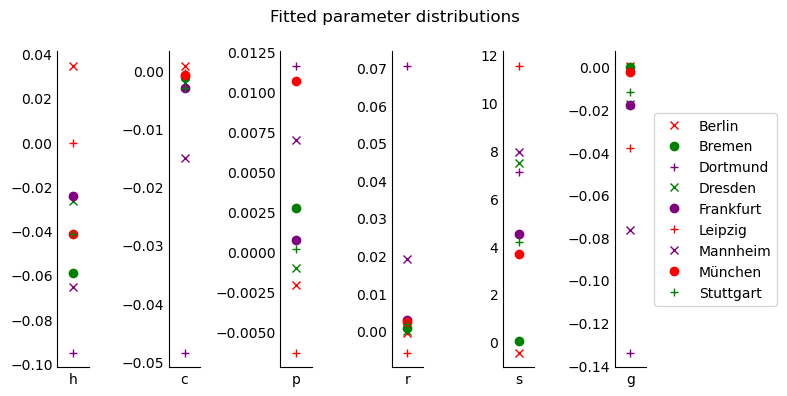

In [77]:
colors = ["red","green","purple","green","purple","red","purple","red","green"]
markers = ["x","o","+"]
fig, axes = plt.subplots(1,6,figsize=(8,4))
for i, row in data_param.iterrows():
    for j, ax in enumerate(axes):
        if j == 5:
            ax.plot(0,row[1+j],label=row["city"], marker=markers[i%3],linestyle="",color=colors[i])
            ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
        else:
            ax.plot(0,row[1+j], marker=markers[i%3],linestyle="",color=colors[i])
        ax.set_xticks([0],labels=[list(row.index)[1+j]])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='both', length=0) 
fig.suptitle("Fitted parameter distributions")
fig.tight_layout();
fig.savefig("../../UHC/parameters.png",dpi=300);

In [7]:
# Left eigenvalues
def normalize(v):
    v_sum = np.sum([abs(i) for i in v if not np.isnan(i)])
    return np.array([i / v_sum if not np.isnan(i) else i for i in v])

def complex_sqrt(values):
    values = np.asarray(values, dtype=complex)  # Ensure values are treated as complex
    return np.sqrt(values)

def compute_u1():
    return np.array([0, 0, 1])

def compute_u2(c, g, h, p, P, r, T):
    u2_1 = (2 * h * p * P + g * p * T + g * complex_sqrt(8 * h * p * P + p**2 * T**2)) / (-4 * h * r + c * p * T + c * complex_sqrt(8 * h * p * P + p**2 * T**2))
    u2_2 = (0.25 * h * (4 * g - p * T + complex_sqrt(8 * h * p * P + p**2 * T**2))) / (h * r - 0.25 * c * p * T - 0.25 * c * complex_sqrt(8 * h * p * P + p**2 * T**2))
    u2 = np.array([u2_1, u2_2, 1])
    # Normalize u2 to ensure it sums up to 1
    return u2 #/ np.sum(u2)

def compute_u3(c, g, h, p, P, r, T):
    u3_1 = (-2 * h * p * P - g * p * T + g * complex_sqrt(8 * h * p * P + p**2 * T**2)) / (4 * h * r - c * p * T + c * complex_sqrt(8 * h * p * P + p**2 * T**2))
    u3_2 = (-0.25 * h * (-4 * g + p * T + complex_sqrt(8 * h * p * P + p**2 * T**2))) / (h * r - 0.25 * c * p * T + 0.25 * c * complex_sqrt(8 * h * p * P + p**2 * T**2))
    u3 = np.array([u3_1, u3_2, 1])
    # Normalize u3 to ensure it sums up to 1
    return u3 #/ np.sum(u3)

def compute_v1(c, g, h, p, P, r, T):
    v1_1 = -(2 * c * g + 2 * h * r - c * p * T) / (2 * g**2 - h * p * P - g * p * T)
    v1_2 = -(-c * p * P - 2 * g * r) / (-2 * g**2 + h * p * P + g * p * T)
    return np.array([v1_1, v1_2, 1]) #/ np.sum([v1_1, v1_2, 1])

def compute_v2(p, h, P, T):
    v2_1 = - (complex_sqrt(p) * T + complex_sqrt(8 * h * P + p * T**2)) / (2 * complex_sqrt(p) * P)
    return np.array([v2_1, 1, 0]) #/ np.sum(np.array([v2_1, 1, 0]) )

def compute_v3(p, h, P, T):
    v3_1 = - (complex_sqrt(p) * T - complex_sqrt(8 * h * P + p * T**2)) / (2 * complex_sqrt(p) * P)
    return np.array([v3_1, 1, 0]) #/ np.sum(np.array([v3_1, 1, 0]))
# Eigenvalues
def compute_lambda1(g):
    return g

def compute_lambda2(p, h, P, T, factor=1):
    term = complex_sqrt(p) * complex_sqrt(8 * h * P + p * T**2)
    return factor*1/4 * (p * T - term)

def compute_lambda3(p, h, P, T, factor=1):
    term = complex_sqrt(p) * complex_sqrt(8 * h * P + p * T**2)
    return factor*1/4 * (term + p * T)

In [8]:
# Equilibria
data_param["T_equ"] = data_param.apply(lambda x: x["h"]*x["r"]/x["c"]/x["p"],axis=1) 
data_param["P_equ"] = data_param.apply(lambda x: - x["c"]*x["s"]/x["g"]/x["h"],axis=1) 
data_param["V_equ"] = data_param.apply(lambda x: -x["s"]/x["g"],axis=1) 
# Eigenvalues at equilibrium
data_param["equ_1"] = data_param.apply(lambda x: compute_lambda1(x["g"]),axis=1)
data_param["equ_2"] = data_param.apply(lambda x: compute_lambda2(x["p"],x["h"],x["P_equ"],x["T_equ"],factor=2),axis=1)
data_param["equ_3"] = data_param.apply(lambda x: compute_lambda3(x["p"],x["h"],x["P_equ"],x["T_equ"],factor=2),axis=1)
# Left eigenvector
data_param["u_1"] = data_param.apply(lambda x: compute_u1(),axis=1)
data_param["u_2"] = data_param.apply(lambda x: compute_u2(x["c"],x["g"],x["h"],x["p"],x["P_equ"],x["r"],x["T_equ"]),axis=1)
data_param["u_3"] = data_param.apply(lambda x: compute_u3(x["c"],x["g"],x["h"],x["p"],x["P_equ"],x["r"],x["T_equ"]),axis=1)
# Right eigenvectors
data_param["v_1"] = data_param.apply(lambda x: compute_v1(x["c"],x["g"],x["h"],x["p"],x["P"],x["r"],x["T"]),axis=1)
data_param["v_2"] = data_param.apply(lambda x: compute_v2(x["p"],x["h"],x["P_equ"],x["T_equ"]),axis=1)
data_param["v_3"] = data_param.apply(lambda x: compute_v3(x["p"],x["h"],x["P_equ"],x["T_equ"]),axis=1)
# Eigenvalues
data_param["e_1"] = data_param.apply(lambda x: compute_lambda1(x["g"]),axis=1)
data_param["e_2"] = data_param.apply(lambda x: compute_lambda2(x["p"],x["h"],x["P"],x["T"]),axis=1)
data_param["e_3"] = data_param.apply(lambda x: compute_lambda3(x["p"],x["h"],x["P"],x["T"]),axis=1)

In [53]:
data_param #.to_csv("../tmp.csv",index=False)

,city,h,c,p,r,s,g,T,P,V,...,equ_3,u_1,u_2,u_3,v_1,v_2,v_3,e_1,e_2,e_3
0,Berlin,0.034445,0.000799,-0.002091,-0.000553,-0.472025,0.000523,9.849523,24.974359,906.292777,...,-0.011934+0.053593j,"[0, 0, 1]","[(-15.87968336229802+24.750148802335687j), (-3...","[(-15.87968336229802-24.750148802335687j), (-3...","[0.011518350529418644, 0.023363080580908312, 1.0]","[(-0.2727226525622154+1.2247063385953716j), (1...","[(-0.2727226525622154-1.2247063385953716j), (1...",0.000523,-0.005148-0.029542j,-0.005148+0.029542j
1,Bremen,-0.059294,-0.001133,0.002725,0.000596,0.010319,-0.000006,10.010285,25.538462,1460.109661,...,0.015597+0.097826j,"[0, 0, 1]","[(-17.225082026372387-36.02458521975845j), (-4...","[(-17.225082026372387+36.02458521975845j), (-4...","[0.009636778025822423, 0.01911195695001242, 1.0]","[(-0.18848115181922398-1.1821767111493495j), (...","[(-0.18848115181922398+1.1821767111493495j), (...",-0.000006,0.006820-0.044909j,0.006820+0.044909j
2,Dortmund,-0.095202,-0.048531,0.011606,0.070488,7.114106,-0.134179,10.214221,25.692308,53.021067,...,0.069137+0.234405j,"[0, 0, 1]","[(-0.15678252075636356-3.3018001565472983j), (...","[(-0.15678252075636356+3.3018001565472983j), (...","[-0.06669404417661066, 0.415774414318516, 1.0]","[(-0.2204068873262143-0.747278072360602j), (1+...","[(-0.2204068873262143+0.747278072360602j), (1+...",-0.134179,0.029636-0.115391j,0.029636+0.115391j
3,Dresden,-0.026764,-0.002237,-0.001018,-0.000127,7.495511,-0.017398,9.102806,30.846154,430.819096,...,-0.045060+0.000000j,"[0, 0, 1]","[(-2.144484537262867-0j), (-2.6365530304722964...","[(18.78008320138848-0j), (-22.309000655973048-...","[0.1613352732883562, 0.1884503306364625, 1.0]","[(-1.2294577016803692+0j), (1+0j), 0j]","[(1.1879074451770084+0j), (1+0j), 0j]",-0.017398,0.018312+0.000000j,-0.022945+0.000000j
4,Frankfurt,-0.024314,-0.002933,0.000718,0.002847,4.509433,-0.017765,10.474919,24.461538,253.724360,...,0.011804+0.030480j,"[0, 0, 1]","[(-1.536575387661818-6.536732758443639j), (-9....","[(-1.536575387661818+6.536732758443639j), (-9....","[0.010259067942848117, 0.12811134198746124, 1.0]","[(-0.537262480425397-1.387347022957211j), (1+0...","[(-0.537262480425397+1.387347022957211j), (1+0...",-0.017765,0.001879-0.014487j,0.001879+0.014487j
5,Leipzig,-0.000443,-0.000515,-0.006326,-0.005891,11.546306,-0.037959,9.974156,29.205128,304.171333,...,-0.047107+0.000000j,"[0, 0, 1]","[(22.5561276032773-0j), (0.4748987915989451-0j...","[(146.01502177017457-0j), (-2.743575718156839-...","[-0.029165788322573334, -1.3387636854670293, 1.0]","[(-0.02105409226049707+0j), (1+0j), 0j]","[(0.018789681259474698+0j), (1+0j), 0j]",-0.037959,0.001247+0.000000j,-0.032793+0.000000j
6,Mannheim,-0.065522,-0.015059,0.006978,0.019129,7.940057,-0.076738,10.856736,21.538462,103.467029,...,0.041616+0.141466j,"[0, 0, 1]","[(-0.411011116448983-6.239796113325489j), (-5....","[(-0.411011116448983+6.239796113325489j), (-5....","[-0.03444955843799832, 0.18948674937638857, 1.0]","[(-0.25079992787499217-0.8525524937997151j), (...","[(-0.25079992787499217+0.8525524937997151j), (...",-0.076738,0.018939-0.067564j,0.018939+0.067564j
7,München,-0.041693,-0.000790,0.010668,0.002419,3.660003,-0.002287,9.408093,28.461538,1601.137737,...,0.063814+0.151375j,"[0, 0, 1]","[(-54.356014985746604-45.2679639459325j), (-31...","[(-54.356014985746604+45.2679639459325j), (-31...","[0.009209763068782741, 0.019460103452721766, 1.0]","[(-0.1971795395495941-0.4677368353329125j), (1...","[(-0.1971795395495941+0.4677368353329125j), (1...",-0.002287,0.025091-0.075498j,0.025091+0.075498j
8,Stuttgart,-0.041701,-0.003057,0.000159,0.001875,4.156378,-0.011991,9.862416,22.076923,346.675951,...,0.012788+0.013138j,"[0, 0, 1]","[(-2.0414045392868956-2.04256097882349j), (-13...","[(-2.0414045392868956+2.04256097882349j), (-13...","[0.17300251513960538, 0.12304876015245637, 1.0]","[(-3.172910352776877-3.259764107140151j), (1+0...","[(-3.172910352776877+3.259764107140151j), (1+0...",-0.011991,0.000391-0.008536j,0.000391+0.008536j


## Longtime analysis

In [60]:
max_indices = [1,1,1,1,1,0,1,1,1]
data_param[["v_1","v_2","v_3"]].apply(lambda x: [np.round(np.linalg.norm(i),5) for i in x], axis=1)
for i, row in data_param[["city","v_1","v_2","v_3"]].iterrows():
    print(row["city"],np.abs(row["v_" + str(max_indices[i]+1)]))

Berlin [1.25470445 1.         0.        ]
Bremen [1.19710773 1.         0.        ]
Dortmund [0.77910443 1.         0.        ]
Dresden [1.2294577 1.        0.       ]
Frankfurt [1.48774418 1.         0.        ]
Leipzig [0.02916579 1.33876369 1.        ]
Mannheim [0.88867675 1.         0.        ]
München [0.50759976 1.         0.        ]
Stuttgart [4.54900232 1.         0.        ]


In [85]:
max_indices = [1,1,1,2,1,2,1,1,1]
data_param[["u_1","u_2","u_3"]].apply(lambda x: [np.round(np.linalg.norm(i),5) for i in x], axis=1)
for i, row in data_param[["city","u_1","u_2","u_3"]].iterrows():
    print(row["city"],np.abs(row["u_" + str(max_indices[i]+1)])/sum(np.abs(row["u_" + str(max_indices[i]+1)])))

Berlin [0.43692722 0.54821453 0.01485825]
Bremen [0.45001442 0.53871574 0.01126984]
Dortmund [0.48039308 0.37427638 0.14533054]
Dresden [0.44619843 0.53004244 0.02375913]
Frankfurt [0.37926676 0.56425191 0.05648134]
Leipzig [0.9750026  0.01831999 0.00667741]
Mannheim [0.48814018 0.43379883 0.07806099]
München [0.65714396 0.33356612 0.00928992]
Stuttgart [0.16962703 0.77163377 0.05873919]


In [58]:
data_param[["city","e_1","e_2","e_3"]].apply(lambda x: (x["city"], max([np.abs(i) for i in x.iloc[1:]])),axis=1), 

(0       (Berlin, 0.029987226576261895)
 1        (Bremen, 0.04542352601496388)
 2       (Dortmund, 0.1341785123401981)
 3       (Dresden, 0.02294487326573751)
 4    (Frankfurt, 0.017764963532485516)
 5       (Leipzig, 0.03795893652031885)
 6      (Mannheim, 0.07673824141383925)
 7       (München, 0.07955774849777217)
 8    (Stuttgart, 0.011991407807399376)
 dtype: object,)

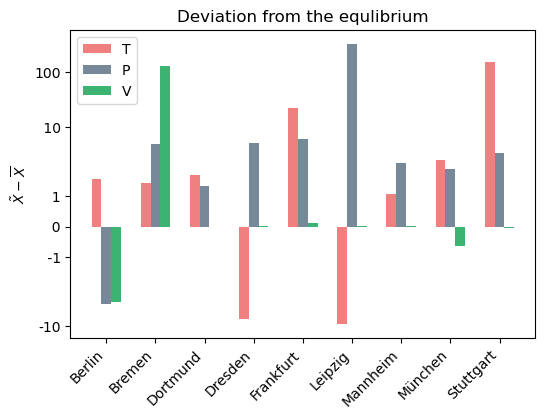

In [76]:
from matplotlib import ticker
X_axis = np.arange(len(data_param["city"]))

fig, axes = plt.subplots(figsize=(6,4))
plt.bar(X_axis - 0.2,data_param["T_equ"]-data_param["T"], 0.2, label = 'T', color="lightcoral") 
plt.bar(X_axis,data_param["P_equ"]-data_param["P"], 0.2, label = 'P', color="lightslategrey") 
plt.bar(X_axis + 0.2, data_param["V_equ"]-data_param["V"], 0.2, label = 'V', color="mediumseagreen")
plt.legend() 
#plt.ylim(-15,25)
plt.yscale("symlog")
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter("%3d"))
plt.ylabel(r"$\tilde{X}-\overline{X}$")
plt.title("Deviation from the equlibrium")
plt.xticks(range(9),data_param["city"],rotation=45, ha='right');
#fig.savefig("../../UHC/equilibria.svg",dpi=300);

In [140]:
np.array([1,2,3,4,5,6])[1:-1]

array([2, 3, 4, 5])

In [125]:
import numpy as np
from scipy.optimize import minimize

berlin_data = data.loc[data["city"] == "Berlin", :]
# Assume data is given as numpy arrays
# t: time array
# T, P, V: observed data arrays for temperature, pressure, and volume respectively
def fit_to_city(cur_data):
    cur_city = cur_data[0]
    cur_data = cur_data[1]
    t = np.array(cur_data["val_idx"])  # time data
    T = np.array(cur_data["T"])  # temperature data
    P = np.array(cur_data["P"])  # pressure data
    V = np.array(cur_data["V"])  # volume data

    # Compute numerical derivatives using finite differences
    dT_dt = np.gradient(T, t)
    dP_dt = np.gradient(P, t)
    dV_dt = np.gradient(V, t)

    # Define the objective function to minimize
    def objective(params):
        h, c, p, r, s, g = params
        residuals_T = dT_dt - (h * P - c * V)
        residuals_P = dP_dt - (p * P * T - r * V)
        residuals_V = dV_dt - (s + g * V)

        # Sum of squared residuals
        return np.sum(residuals_T**2 + residuals_P**2 + residuals_V**2)

    # Initial guess for the parameters
    initial_guess = [1, 1, 1, 1, 1, 1]

    # Perform the optimization
    result = minimize(objective, initial_guess, tol=1e-10,
                      options={"disp":False, "maxiter":10000}, method = 'Nelder-Mead')

    # Extract the optimized parameters
    h, c, p, r, s, g = result.x
    pred_dT_dt = (h * P - c * V)
    pred_dP_dt = (p * P * T - r * V)
    pred_dV_dt = (s + g * V)
    new_df_data = {
        "city": cur_city,
        "year" : cur_data["year"].to_numpy(),
        "true_dT_dt": dT_dt,
        "true_dP_dt": dP_dt,
        "true_dV_dt": dV_dt,
        "pred_dT_dt" : pred_dT_dt,
        "pred_dP_dt" : pred_dP_dt,
        "pred_dV_dt" : pred_dV_dt,
        "pred_T": np.concatenate(
            ([T[0], T[0] + pred_dT_dt[0]],
            pred_dT_dt[1:-1]*2 + cur_data["T"].shift(2).dropna())),
        "pred_P": np.concatenate(
            ([P[0], P[0] + pred_dP_dt[0]],
            pred_dP_dt[1:-1]*2 + cur_data["P"].shift(2).dropna())),
        "pred_V": np.concatenate(
            ([V[0], V[0] + pred_dV_dt[0]],
            pred_dV_dt[1:-1]*2 + cur_data["V"].shift(2).dropna())),
        "T" : np.array(cur_data["T"]),
        "P" : np.array(cur_data["P"]),
        "V" : np.array(cur_data["V"])
    }
    return (pd.DataFrame(new_df_data), 
            dict(zip(["h", "c", "p", "r", "s", "g"], result.x)))

In [126]:
pred_dT = lambda in_var, in_para:(in_para["h"] * in_var["P"] - in_para["c"] * in_var["V"])
pred_dP = lambda in_var, in_para:(in_para["p"] * in_var["P"] * in_var["T"] - in_para["r"] * in_var["V"])
pred_dV = lambda in_var, in_para:(in_para["s"] + in_para["g"] * in_var["V"])

In [127]:
res = [fit_to_city(cur_data) for cur_data in cities_df]

In [ ]:
res_df = [cur_df for cur_df in pd.concat([cur_res[0] for cur_res in res]).groupby("city")]

In [152]:
res_df[0][1]["year"]

0     2002
1     2003
2     2004
3     2005
4     2006
5     2007
6     2008
7     2009
8     2010
9     2011
10    2012
11    2013
12    2014
Name: year, dtype: int64

In [155]:
def plot_pred(data, true_var, pred_var, y_label, n_col = 3, n_row = 3):
    fig, axs = plt.subplots(n_row, n_col, figsize = (10, 10))
    for cur_col in range(n_col):
        for cur_row in range(n_row):
            cur_df_id = cur_col * n_col + cur_row
            cur_df = data[cur_df_id][1]
            cur_x = cur_col
            cur_y = cur_row
            axs[cur_x, cur_y].scatter(cur_df["year"].to_numpy(),
                cur_df[true_var], marker = "x", label = "Data")
            axs[cur_x, cur_y].plot(cur_df["year"].to_numpy(), cur_df[pred_var],
                label = "pred", color = "orange")
            axs[cur_x, cur_y].set_xlabel("Year")
            axs[cur_x, cur_y].set_ylabel(y_label)
            axs[cur_x, cur_y].legend()
            axs[cur_x, cur_y].set_title(cities_df[cur_df_id][0])
            #axs[cur_x, cur_y].ticklabel_format(useOffset=False)
            axs[cur_x, cur_y].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            # axs[cur_x, cur_y].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

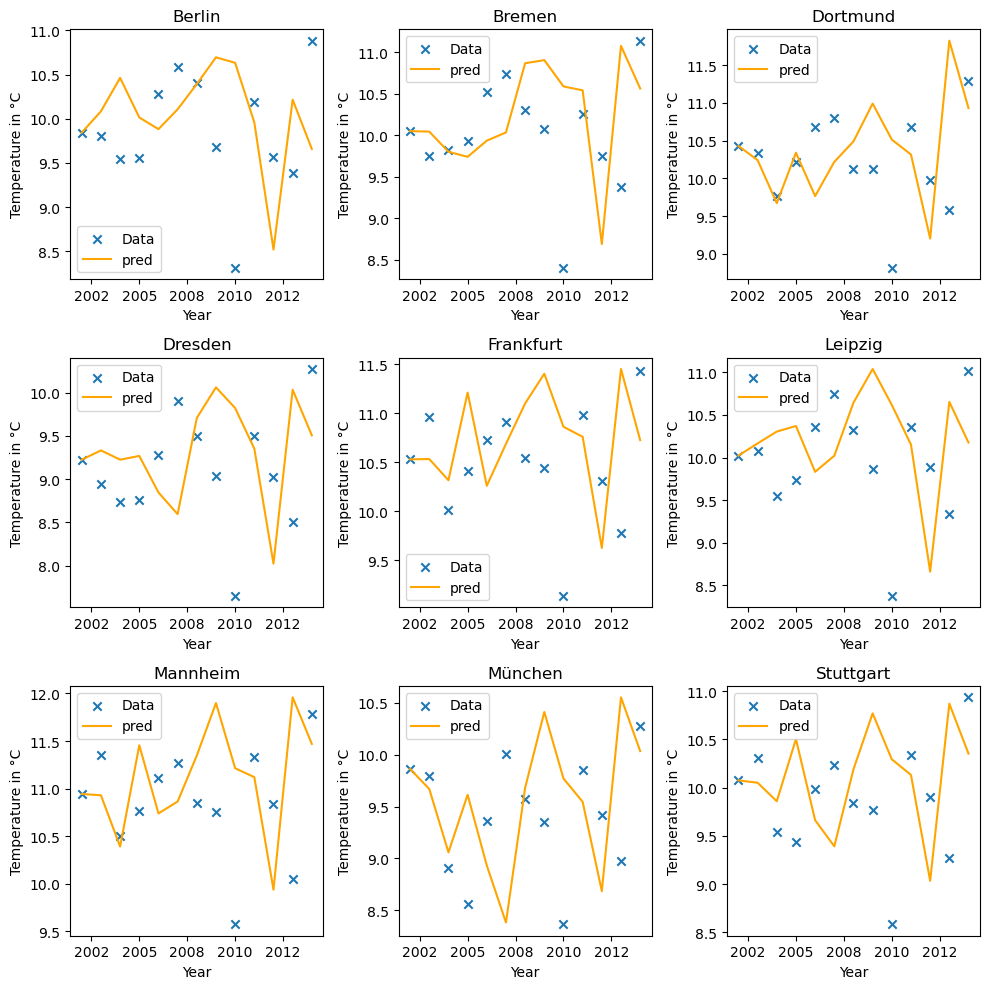

In [156]:
plot_pred(res_df, "T", "pred_T", "Temperature in °C")
plt.tight_layout()

In [60]:
def plot_grad(data, in_var, target_var, res_paras, fixed_vars, x_label, y_label, cur_f, n_col = 3, n_row = 3):
    fig, axs = plt.subplots(n_row, n_col, figsize = (10, 10))
    for cur_col in range(n_col):
        for cur_row in range(n_row):
            cur_df_id = cur_col * n_col + cur_row
            cur_x = cur_col
            cur_y = cur_row
            cur_paras = res_paras[cur_df_id]
            cur_df = data[cur_df_id][1]
            fixed_para = [cur_df[cur_fixed_var].mean() for cur_fixed_var in fixed_vars]
            free_var = [cur_var for cur_var in in_var if cur_var not in fixed_vars][0]
            axs[cur_x, cur_y].scatter(cur_df[free_var],
                cur_df[target_var], marker = "x", label = "Data")
            plot_data = dict(zip(fixed_vars, fixed_para))
            plot_data[free_var] = np.array(cur_df[free_var])
            axs[cur_x, cur_y].plot(cur_df[free_var], cur_f(plot_data, cur_paras),
                label = "pred", color = "orange")
            axs[cur_x, cur_y].set_xlabel(x_label)
            axs[cur_x, cur_y].set_ylabel(y_label)
            axs[cur_x, cur_y].legend()
            axs[cur_x, cur_y].set_title(cities_df[cur_df_id][0])
            axs[cur_x, cur_y].ticklabel_format(useOffset=False)
            axs[cur_x, cur_y].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            axs[cur_x, cur_y].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

In [ ]:
res_df = [cur_df for cur_df in pd.concat([cur_res[0] for cur_res in res]).groupby("city")]
res_paras = [cur_res[1] for cur_res in res]

## Predict delta Temperature

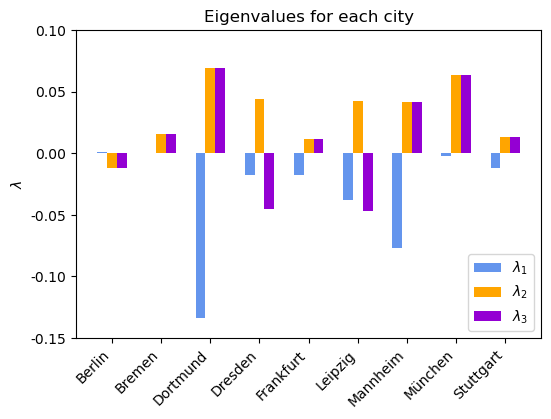

In [81]:
from matplotlib import ticker
X_axis = np.arange(len(data_param["city"]))

fig, axes = plt.subplots(figsize=(6,4))
plt.bar(X_axis - 0.2,data_param["equ_1"].apply(lambda x: x.real), 0.2, label = r'$\lambda_1$', color="cornflowerblue") 
plt.bar(X_axis,data_param["equ_2"].apply(lambda x: x.real), 0.2, label = r'$\lambda_2$', color="orange") 
plt.bar(X_axis + 0.2, data_param["equ_3"].apply(lambda x: x.real), 0.2, label = r'$\lambda_3$', color="darkviolet")
plt.legend(loc="lower right") 
plt.ylim(-0.15,0.1)
plt.yscale("linear")
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter("%3.2f"))
plt.ylabel(r"$\lambda$")
plt.title("Eigenvalues for each city")
plt.xticks(range(9),data_param["city"],rotation=45, ha='right');
fig.savefig("../../UHC/eigenvalues.svg",dpi=300);